In [2]:
import numpy as np

sub_data = np.fromfile('sub_data.txt')

print(sub_data.shape)

import matplotlib.pyplot as plt
%matplotlib inline

(559005,)


In [3]:
from numpy import *
from scipy.optimize import fmin_bfgs
from scipy.special import gamma as gamma_fun
from scipy.special import iv as modified_bessel_2ndkind
from scipy.special import ivp as modified_bessel_2ndkind_derivative
from scipy.stats import uniform
# to avoid confusion with the norm of a vector we give the normal distribution a less confusing name here
from scipy.stats import norm as gauss 
from scipy.linalg import eig
import sys
import warnings

from numpy.random import seed, uniform


#helper function
def MMul(A, B):
    return inner(A, transpose(B))

#helper function to compute the L2 norm. scipy.linalg.norm is not used because this function does not allow to choose an axis
def norm(x, axis=None):
    if isinstance(x, list) or isinstance(x, tuple):
        x = array(x)
    return sqrt(sum(x*x, axis=axis))

def kent(theta, phi, psi, kappa, beta):
    """
  Generates the Kent distribution based on the spherical coordinates theta, phi, psi
  with the concentration parameter kappa and the ovalness beta
    """
    gamma1, gamma2, gamma3 = KentDistribution.spherical_coordinates_to_gammas(theta, phi, psi)
    k = KentDistribution(gamma1, gamma2, gamma3, kappa, beta)
    return k

def kent2(gamma1, gamma2, gamma3, kappa, beta):
    """
  Generates the Kent distribution using the orthonormal vectors gamma1, 
  gamma2 and gamma3, with the concentration parameter kappa and the ovalness beta
    """
    assert abs(inner(gamma1, gamma2)) < 1E-10
    assert abs(inner(gamma2, gamma3)) < 1E-10
    assert abs(inner(gamma3, gamma1)) < 1E-10
    return KentDistribution(gamma1, gamma2, gamma3, kappa, beta)
    
def kent3(A, B):
    """
  Generates the Kent distribution using the orthogonal vectors A and B
  where A = gamma1*kappa and B = gamma2*beta (gamma3 is inferred)
  A may have not have length zero but may be arbitrarily close to zero
  B may have length zero however. If so, then an arbitrary value for gamma2
  (orthogonal to gamma1) is chosen
    """
    kappa = norm(A)
    beta = norm(B)
    gamma1 = A/kappa
    if beta == 0.0:
        gamma2 = __generate_arbitrary_orthogonal_unit_vector(gamma1)
    else:
        gamma2 = B/beta
    theta, phi, psi = KentDistribution.gammas_to_spherical_coordinates(gamma1, gamma2)
    gamma1, gamma2, gamma3 = KentDistribution.spherical_coordinates_to_gammas(theta, phi, psi)
    return KentDistribution(gamma1, gamma2, gamma3, kappa, beta)
  
def kent4(Gamma, kappa, beta):
    """
  Generates the kent distribution
    """
    gamma1 = Gamma[:,0]
    gamma2 = Gamma[:,1]
    gamma3 = Gamma[:,2]
    return kent2(gamma1, gamma2, gamma3, kappa, beta)

def __generate_arbitrary_orthogonal_unit_vector(x):
    v1 = cross(x, array([1.0, 0.0, 0.0]))
    v2 = cross(x, array([0.0, 1.0, 0.0]))
    v3 = cross(x, array([0.0, 0.0, 1.0]))
    v1n = norm(v1)
    v2n = norm(v2)
    v3n = norm(v3)
    v = [v1, v2, v3][argmax([v1n, v2n, v3n])]
    return v/norm(v)
  
class KentDistribution(object):
    minimum_value_for_kappa = 1E-6
    @staticmethod
    def create_matrix_H(theta, phi):
        return array([
            [cos(theta),          -sin(theta),         0.0      ],
            [sin(theta)*cos(phi), cos(theta)*cos(phi), -sin(phi)],
            [sin(theta)*sin(phi), cos(theta)*sin(phi), cos(phi) ]])

    @staticmethod
    def create_matrix_Ht(theta, phi):
        return transpose(KentDistribution.create_matrix_H(theta, phi))

    @staticmethod
    def create_matrix_K(psi):
        return array([
            [1.0, 0.0,      0.0      ],
            [0.0, cos(psi), -sin(psi)],
            [0.0, sin(psi), cos(psi) ]])  
  
    @staticmethod
    def create_matrix_Kt(psi):
        return transpose(KentDistribution.create_matrix_K(psi)) 
  
    @staticmethod
    def create_matrix_Gamma(theta, phi, psi):
        H = KentDistribution.create_matrix_H(theta, phi)
        K = KentDistribution.create_matrix_K(psi)
        return MMul(H, K)
  
    @staticmethod
    def create_matrix_Gammat(theta, phi, psi):
        return transpose(KentDistribution.create_matrix_Gamma(theta, phi, psi))
  
    @staticmethod
    def spherical_coordinates_to_gammas(theta, phi, psi):
        Gamma = KentDistribution.create_matrix_Gamma(theta, phi, psi)
        gamma1 = Gamma[:,0]
        gamma2 = Gamma[:,1]
        gamma3 = Gamma[:,2]    
        return gamma1, gamma2, gamma3

    @staticmethod
    def gamma1_to_spherical_coordinates(gamma1):
        theta = arccos(gamma1[0])
        phi = arctan2(gamma1[2], gamma1[1])
        return theta, phi

    @staticmethod
    def gammas_to_spherical_coordinates(gamma1, gamma2):
        theta, phi = KentDistribution.gamma1_to_spherical_coordinates(gamma1)
        Ht = KentDistribution.create_matrix_Ht(theta, phi)
        u = MMul(Ht, reshape(gamma2, (3, 1)))
        psi = arctan2(u[2][0], u[1][0])
        return theta, phi, psi

  
    def __init__(self, gamma1, gamma2, gamma3, kappa, beta):
        self.gamma1 = array(gamma1, dtype=float64)
        self.gamma2 = array(gamma2, dtype=float64)
        self.gamma3 = array(gamma3, dtype=float64)
        self.kappa = float(kappa)
        self.beta = float(beta)
    
        self.theta, self.phi, self.psi = KentDistribution.gammas_to_spherical_coordinates(self.gamma1, self.gamma2)
    
        for gamma in gamma1, gamma2, gamma3:
            assert len(gamma) == 3

        self._cached_rvs = array([], dtype=float64)
        self._cached_rvs.shape = (0, 3)
  
    @property
    def Gamma(self):
        return self.create_matrix_Gamma(self.theta, self.phi, self.psi)
  
    def normalize(self, cache=dict(), return_num_iterations=False):
        """
    Returns the normalization constant of the Kent distribution.
    The proportional error may be expected not to be greater than 
    1E-11.
    
    
    >>> gamma1 = array([1.0, 0.0, 0.0])
    >>> gamma2 = array([0.0, 1.0, 0.0])
    >>> gamma3 = array([0.0, 0.0, 1.0])
    >>> tiny = KentDistribution.minimum_value_for_kappa
    >>> abs(kent2(gamma1, gamma2, gamma3, tiny, 0.0).normalize() - 4*pi) < 4*pi*1E-12
    True
    >>> for kappa in [0.01, 0.1, 0.2, 0.5, 2, 4, 8, 16]:
    ...     print abs(kent2(gamma1, gamma2, gamma3, kappa, 0.0).normalize() - 4*pi*sinh(kappa)/kappa) < 1E-15*4*pi*sinh(kappa)/kappa,
    ... 
    True True True True True True True True
        """
        k, b = self.kappa, self.beta
        if not (k, b) in cache:
            G = gamma_fun
            I = modified_bessel_2ndkind
            result = 0.0
            j = 0
            if b == 0.0:
                result = (
                      ( (0.5*k)**(-2*j-0.5) )*
                      ( I(2*j+0.5, k) )
                         )
                result /= G(j+1)
                result *= G(j+0.5)
        
            else:
                while True:
                    a = (
                        exp(
                          log(b)*2*j +
                          log(0.5*k)*(-2*j-0.5)
                           )*I(2*j+0.5, k)
                          )
                    a /= G(j+1)
                    a *= G(j+0.5)
                    result += a
          
                    j += 1
                    if abs(a) < abs(result)*1E-12 and j > 5:
                        break
              
            cache[k, b] = 2*pi*result
        if return_num_iterations:
            return cache[k, b], j
        else:
            return cache[k, b]

    def log_normalize(self, return_num_iterations=False):
        """
    Returns the logarithm of the normalization constant.
        """
        if return_num_iterations:
            normalize, num_iter = self.normalize(return_num_iterations=True)
            return log(normalize), num_iter
        else:
            return log(self.normalize())
      
  
    def pdf_max(self, normalize=True):
        return exp(self.log_pdf_max(normalize))

    def log_pdf_max(self, normalize=True):
        """
    Returns the maximum value of the log(pdf)
        """
        if self.beta == 0.0:
            x = 1
        else:
            x = self.kappa*1.0/(2*self.beta)
        if x > 1.0:
            x = 1
        fmax = self.kappa*x + self.beta*(1-x**2)
        if normalize:
            return fmax - self.log_normalize()
        else:
            return fmax
    
    def pdf(self, xs, normalize=True):
        """
    Returns the pdf of the kent distribution for 3D vectors that
    are stored in xs which must be an array of N x 3 or N x M x 3
    N x M x P x 3 etc.
    
    The code below shows how points in the pdf can be evaluated. An integral is
    calculated using random points on the sphere to determine wether the pdf is
    properly normalized.
    
    >>> from numpy.random import seed
    >>> from scipy.stats import norm as gauss
    >>> seed(666)
    >>> num_samples = 400000
    >>> xs = gauss(0, 1).rvs((num_samples, 3))
    >>> xs = divide(xs, reshape(norm(xs, 1), (num_samples, 1)))
    >>> assert abs(4*pi*average(kent(1.0, 1.0, 1.0, 4.0,  2.0).pdf(xs)) - 1.0) < 0.01
    >>> assert abs(4*pi*average(kent(1.0, 2.0, 3.0, 4.0,  2.0).pdf(xs)) - 1.0) < 0.01
    >>> assert abs(4*pi*average(kent(1.0, 2.0, 3.0, 4.0,  8.0).pdf(xs)) - 1.0) < 0.01
    >>> assert abs(4*pi*average(kent(1.0, 2.0, 3.0, 16.0, 8.0).pdf(xs)) - 1.0) < 0.01
        """
        return exp(self.log_pdf(xs, normalize))
  
  
    def log_pdf(self, xs, normalize=True):
        """
    Returns the log(pdf) of the kent distribution.
        """
        axis = len(shape(xs))-1
        g1x = sum(self.gamma1*xs, axis)
        g2x = sum(self.gamma2*xs, axis)
        g3x = sum(self.gamma3*xs, axis)
        k, b = self.kappa, self.beta

        f = k*g1x + b*(g2x**2 - g3x**2)
        if normalize:
            return f - self.log_normalize()
        else:
            return f
      
    def pdf_prime(self, xs, normalize=True):
        """
    Returns the derivative of the pdf with respect to kappa and beta. 
        """
        return self.pdf(xs, normalize)*self.log_pdf_prime(xs, normalize)
    
    def log_pdf_prime(self, xs, normalize=True):
        """
    Returns the derivative of the log(pdf) with respect to kappa and beta.
        """
        axis = len(shape(xs))-1
        g1x = sum(self.gamma1*xs, axis)
        g2x = sum(self.gamma2*xs, axis)
        g3x = sum(self.gamma3*xs, axis)
        k, b = self.kappa, self.beta

        dfdk = g1x
        dfdb = g2x**2 - g3x**2
        df = array([dfdk, dfdb])
        if normalize:
            return transpose(transpose(df) - self.log_normalize_prime())
        else:
            return df
          
    def normalize_prime(self, cache=dict(), return_num_iterations=False):
        """
    Returns the derivative of the normalization factor with respect to kappa and beta.
        """
        k, b = self.kappa, self.beta
        if not (k, b) in cache:
            G = gamma_fun
            I = modified_bessel_2ndkind
            dIdk = lambda v, z : modified_bessel_2ndkind_derivative(v, z, 1)
            dcdk, dcdb = 0.0, 0.0
            j = 0
            if b == 0:
                dcdk = (
                  ( G(j+0.5)/G(j+1) )*
                  ( (-0.5*j-0.125)*(k)**(-2*j-1.5) )*
                  ( I(2*j+0.5, k) )
                        )
                dcdk += (
                  ( G(j+0.5)/G(j+1) )*
                  ( (0.5*k)**(-2*j-0.5) )*
                  ( dIdk(2*j+0.5, k) )
                        )   

                dcdb = 0.0 
            else:
                while True:
                    dk = (
                        (-1*j-0.25)*exp(
                        log(b)*2*j + 
                        log(0.5*k)*(-2*j-1.5)
                        )*I(2*j+0.5, k)
                          )
                    dk += (
                        exp(
                        log(b)*2*j +
                        log(0.5*k)*(-2*j-0.5)
                        )*dIdk(2*j+0.5, k)
                          )        
                    dk /= G(j+1)
                    dk *= G(j+0.5)                        

                    db = (
                        2*j*exp(
                        log(b)*(2*j-1) +
                        log(0.5*k)*(-2*j-0.5)
                        ) * I(2*j+0.5, k)
                          )
                    db /= G(j+1)
                    db *= G(j+0.5)                     
                    dcdk += dk
                    dcdb += db
        
                    j += 1
                    if abs(dk) < abs(dcdk)*1E-12 and abs(db) < abs(dcdb)*1E-12  and j > 5:
                        break
      
        # print "dc", dcdk, dcdb, "(", k, b
      
            cache[k, b] = 2*pi*array([dcdk, dcdb])
        if return_num_iterations:
            return cache[k, b], j
        else:
            return cache[k, b]
    
    def log_normalize_prime(self, return_num_iterations=False):
        """
    Returns the derivative of the logarithm of the normalization factor.
        """
        if return_num_iterations:
            normalize_prime, num_iter = self.normalize_prime(return_num_iterations=True)
            return normalize_prime/self.normalize(), num_iter
        else:
            return self.normalize_prime()/self.normalize()

    def log_likelihood(self, xs):
        """
    Returns the log likelihood for xs.
        """
        retval = self.log_pdf(xs)
        return sum(retval, len(shape(retval)) - 1)
    
    def log_likelihood_prime(self, xs):
        """
    Returns the derivative with respect to kappa and beta of the log likelihood for xs.
        """
        retval = self.log_pdf_prime(xs)
        if len(shape(retval)) == 1:
            return retval
        else:
            return sum(retval, len(shape(retval)) - 1)
    
    def _rvs_helper(self):
        num_samples = 10000
        xs = gauss(0, 1).rvs((num_samples, 3))
        xs = divide(xs, reshape(norm(xs, 1), (num_samples, 1)))
        pvalues = self.pdf(xs, normalize=False)
        fmax = self.pdf_max(normalize=False)
        return xs[uniform(0, fmax, num_samples) < pvalues]
  
    def rvs(self, n_samples=None):
        """
    Returns random samples from the Kent distribution by rejection sampling. 
    May become inefficient for large kappas.

    The returned random samples are 3D unit vectors.
    If n_samples == None then a single sample x is returned with shape (3,)
    If n_samples is an integer value N then N samples are returned in an array with shape (N, 3)
        """
        num_samples = 1 if n_samples == None else n_samples
        rvs = self._cached_rvs
        while len(rvs) < num_samples:
            new_rvs = self._rvs_helper()
            rvs = concatenate([rvs, new_rvs])
        if n_samples == None:
            self._cached_rvs = rvs[1:]
            return rvs[0]
        else:
            self._cached_rvs = rvs[num_samples:]
            retval = rvs[:num_samples]
            return retval
      
    def __repr__(self):
        return "kent(%s, %s, %s, %s, %s)" % (self.theta, self.phi, self.psi, self.kappa, self.beta)
      
def kent_me(xs):
    """
    Generates and returns a KentDistribution based on a moment estimation.
    """
    lenxs = len(xs)
    xbar = average(xs, 0) # average direction of samples from origin
    S = average(xs.reshape((lenxs, 3, 1))*xs.reshape((lenxs, 1, 3)), 0) # dispersion (or covariance) matrix around origin
    gamma1 = xbar/norm(xbar) # has unit length and is in the same direction and parallel to xbar
    theta, phi = KentDistribution.gamma1_to_spherical_coordinates(gamma1)

    H = KentDistribution.create_matrix_H(theta, phi)
    Ht = KentDistribution.create_matrix_Ht(theta, phi)
    B = MMul(Ht, MMul(S, H))

    eigvals, eigvects = eig(B[1:,1:])
    eigvals = real(eigvals)
    if eigvals[0] < eigvals[1]:
        eigvals[0], eigvals[1] = eigvals[1], eigvals[0]
        eigvects = eigvects[:,::-1]
    K = diag([1.0, 1.0, 1.0])
    K[1:,1:] = eigvects

    G = MMul(H, K)
    Gt = transpose(G)
    T = MMul(Gt, MMul(S, G))

    r1 = norm(xbar)
    t22, t33 = T[1, 1], T[2, 2]
    r2 = t22 - t33

# kappa and beta can be estimated but may not lie outside their permitted ranges
    min_kappa = KentDistribution.minimum_value_for_kappa
    kappa = max( min_kappa, 1.0/(2.0-2.0*r1-r2) + 1.0/(2.0-2.0*r1+r2)  )
    beta  = 0.5*(1.0/(2.0-2.0*r1-r2) - 1.0/(2.0-2.0*r1+r2))

    return kent4(G, kappa, beta)  

def __kent_mle_output1(k_me, callback):
    print()
    print("******** Maximum Likelihood Estimation ********")
    print("Initial moment estimates are:")
    print("theta = ", k_me.theta)
    print("phi  = ", k_me.phi)
    print("psi  = ", k_me.psi)
    print("kappa = ", k_me.kappa)
    print("beta = ", k_me.beta)
    print("******** Starting the Gradient Descent ********")
    print("[iteration]   kappa        beta        -L")

def __kent_mle_output2(x, minusL, output_count, verbose):
    interval = verbose if isinstance(verbose, int) else 1
    str_values = list()
    for value in (tuple(x) + (minusL,)):
        str_value = "%- 8g" % value
        while len(str_value) < 12:
            str_value += " "
        str_values.append(str_value)
    if output_count[0] % interval == 0:
        print("[%3i]       " + " %s" * 3) % tuple(output_count + str_values)
    output_count[0] = output_count[0] + 1

def kent_mle(xs, verbose=False, return_intermediate_values=False, return_bfgs_values=False, bfgs_kwargs=dict(), warning='warn'):
    """
Generates a KentDistribution fitted to xs using maximum likelihood estimation
For a first approximation kent_me() is used. The function 
-k.log_likelihood(xs)/len(xs) (where k is an instance of KentDistribution) is 
minimized.

Input:
- xs: values on the sphere to be fitted by MLE
- verbose: if True, output is given for every step
- return_intermediate_values: if true the values of all intermediate steps
  are returned as well
- return_bfgs_values: if true the values from the bfgs_min algorithm are 
  returned as well
- bfgs_args: extra arguments that can be passed to min_bfgs: not all arguments may
  be overwritten. Default value of 'disp' is 0 but may be set to 1 'full_output'
  'gtol' is chosen to be 1E-7 but may be set to other values.
  is 1 (can't be overwritten), 'callback' can't be overwritten and the first 
  three arguments of min_bfgs can't be overwritten. 
- warning: choices are 
  - "warn": issues any warning via warning.warn
  - a file object: which results in any warning message being written to a file 
    (e.g. stdout) 
  - "none": or any other value for this argument results in no warnings to be issued
Output:
- an instance of the fitted KentDistribution
Extra output:
- if return_intermediate_values and/or return_bfgs_values is specified then
a tuple is returned with the KentDistribution argument as the first element
and containing the extra requested values in the rest of the elements.
    """
    # first get estimated moments
    if 'disp' not in bfgs_kwargs:
        bfgs_kwargs['disp'] = 0
    if 'gtol' not in bfgs_kwargs:
        bfgs_kwargs['gtol'] = 1E-7
    k_me = kent_me(xs)
    gamma1, gamma2, gamma3, kappa, beta = k_me.gamma1, k_me.gamma2, k_me.gamma3, k_me.kappa, k_me.beta
    min_kappa = KentDistribution.minimum_value_for_kappa

# method that generates an instance of KentDistribution
    def generate_k(fudge_kappa, fudge_beta):
        # small value is added to kappa = min_kappa + abs(fudge_kappa) > min_kappa
        return kent2(gamma1, gamma2, gamma3, min_kappa + abs(fudge_kappa), abs(fudge_beta))

# method that generates the minus L to be minimized
    def minus_log_likelihood(x):
        return -generate_k(*x).log_likelihood(xs)/len(xs)

    def minus_log_likelihood_prime(x):
        return -generate_k(*x).log_likelihood_prime(xs)/len(xs)

# callback for keeping track of the values
    intermediate_values = list()
    def callback(x, output_count=[0]):
        minusL = -generate_k(*x).log_likelihood(xs)
        fudge_kappa, fudge_beta = x
        kappa, beta = min_kappa + abs(fudge_kappa), abs(fudge_beta)
        imv = intermediate_values
        imv.append((kappa, beta, minusL))

# starting parameters (small value is subtracted from kappa and add in generatke k)
    x_start = array([kappa - min_kappa, beta])
    if verbose:
        __kent_mle_output1(k_me, callback)


# here the mle is done
    all_values = fmin_bfgs(minus_log_likelihood, x_start, minus_log_likelihood_prime,
            callback=callback, full_output=1, **bfgs_kwargs)

    x_opt = all_values[0]
    warnflag = all_values[6]
    warning_message = None
    if warnflag:
        warning_message = "Unknownw warning %s" % warnflag
    if warnflag == 2:
        warning_message = "Desired error not necessarily achieved due to precision loss."
    if warnflag == 1:
        warning_message = "Maximum number of iterations has been exceeded."
    if warning == "warn":
        warnings.warn(warning_message, RuntimeWarning)
    if hasattr(warning, "write") and warning_message is not None:
        warning.write("Warning: "+warning_message+"\n")

    k = (generate_k(*x_opt),)
    if return_intermediate_values:
        k += (intermediate_values,)
    if  return_bfgs_values:
        k += (all_values,)
    if len(k) == 1:
        k = k[0]
    return k

In [4]:
n = sub_data.shape[0]

sub_data = np.reshape(sub_data, (int(n/5), 5))

sub_data[:5]

array([[ 0.        ,  1.        , 12.96193846,  0.602894  ,  4.54008123],
       [ 0.        ,  1.        ,  6.77599851,  1.20618048,  3.76882457],
       [ 0.        ,  1.        ,  9.44071993,  1.13422512,  0.09576866],
       [ 0.        ,  1.        , 12.03416768,  2.17699827,  4.75426578],
       [ 0.        ,  1.        , 14.05010736,  0.14042344,  5.29959809]])

In [5]:
sub_data.shape

(111801, 5)

In [6]:
angle_pairs_with_rs = (sub_data[:,2], sub_data[:,3:])

In [7]:
rs, angle_pairs = angle_pairs_with_rs
print(rs[:5], angle_pairs[:5])

[12.96193846  6.77599851  9.44071993 12.03416768 14.05010736] [[0.602894   4.54008123]
 [1.20618048 3.76882457]
 [1.13422512 0.09576866]
 [2.17699827 4.75426578]
 [0.14042344 5.29959809]]


In [8]:
discretisation_bins = {}
for r in range(4, 20):
    discretisation_bins[r] = sub_data[:, 3:5][(sub_data[:, 2] > r-1/2)*(sub_data[:, 2] <= r+1/2)]

In [9]:
len(discretisation_bins[4])

433

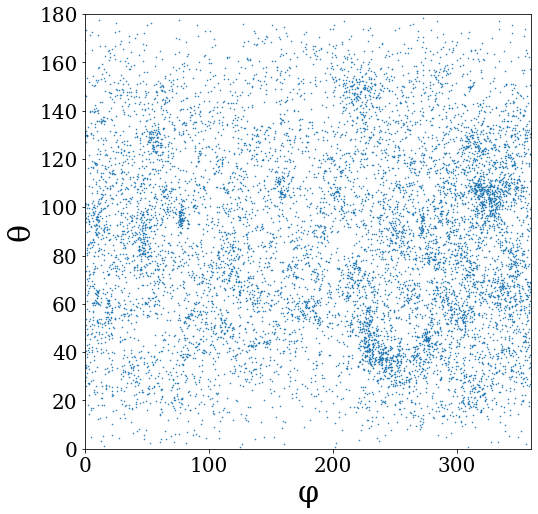

In [263]:

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40



theta, phi = discretisation_bins[15].T
plt.figure(figsize = (8,8))
s = 3000/len(theta)


plt.xlim(0, 360)
plt.ylim(0, 180)
plt.xlabel('\u03C6', fontsize = 30)
plt.ylabel('\u03B8', fontsize = 30)
plt.scatter(phi*180/pi, theta*180/pi, s = s)
plt.show()

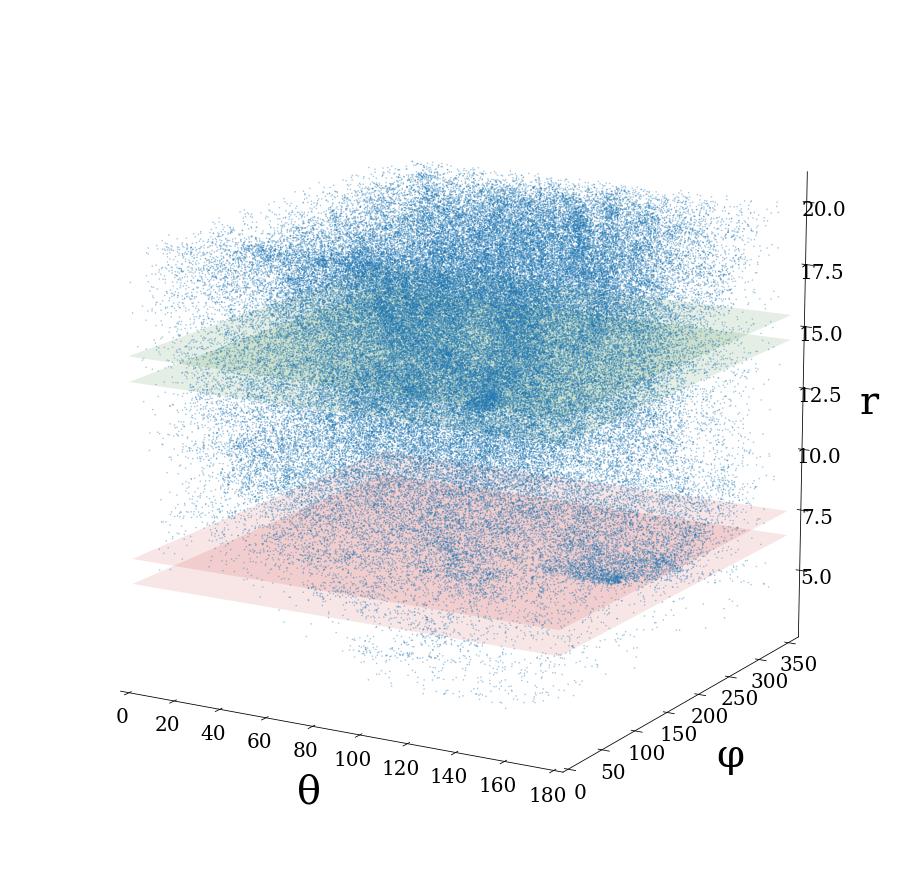

In [116]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40


fig = plt.figure(figsize =(16,16))
ax = fig.add_subplot(111, projection='3d')


ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#ax.set_axis_off()

theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 361)

Theta, Phi = np.meshgrid(theta, phi)

R_1 = np.ones(Theta.shape)*6.5

R_2 = np.ones(Theta.shape)*7.5

R_3 = np.ones(Theta.shape)*14.5

R_4 = np.ones(Theta.shape)*15.5

ax.plot_surface(Theta, Phi, R_1, color = 'red', alpha = 0.1)
ax.plot_surface(Theta, Phi, R_2, color = 'red', alpha = 0.1)

ax.plot_surface(Theta, Phi, R_3, color = 'green', alpha = 0.1)
ax.plot_surface(Theta, Phi, R_4, color = 'green', alpha = 0.1)

ax.scatter(sub_data[:,3]*180/pi, sub_data[:,4]*180/pi, sub_data[:,2], s = 35000/sub_data.shape[0], alpha = 0.4)
ax.set_xlim(0, 180)
ax.set_ylim(0, 360)

ax.view_init(15)

ax.set_xlabel('\u03B8', labelpad=25, fontsize = 40)
ax.set_ylabel('\u03C6', labelpad=25, fontsize = 40)
ax.set_zlabel('r', labelpad=25, fontsize = 40)
plt.show()

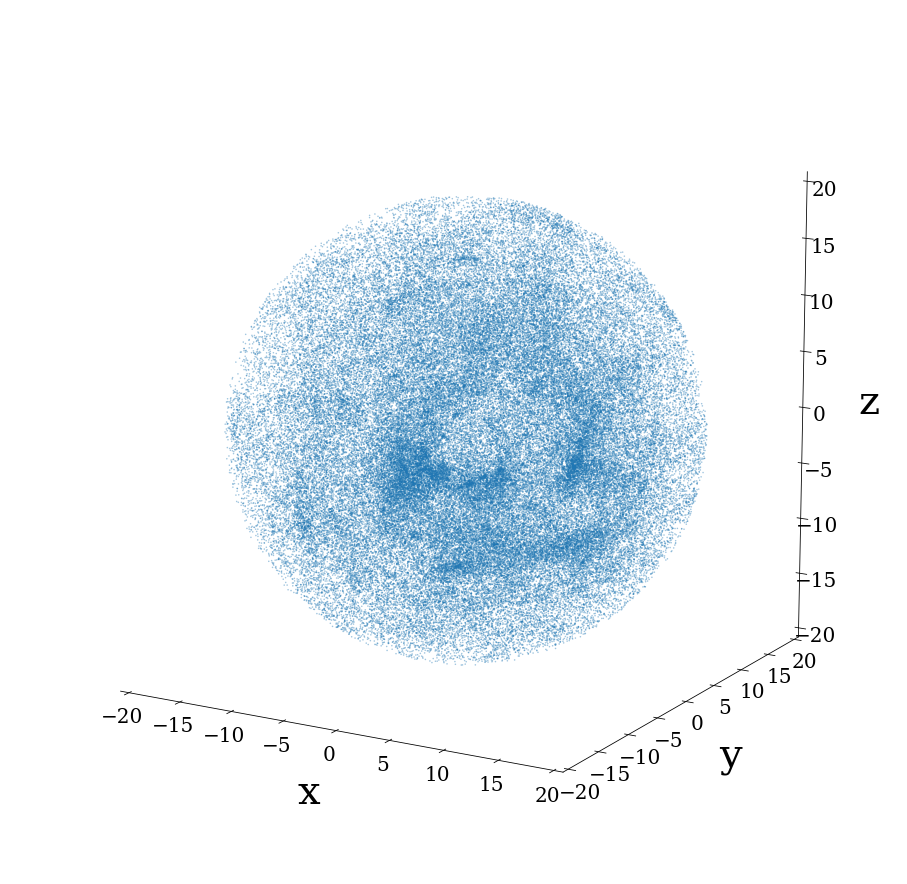

In [124]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40


fig = plt.figure(figsize =(16,16))
ax = fig.add_subplot(111, projection='3d')


ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#ax.set_axis_off()

theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 361)

Theta, Phi = np.meshgrid(theta, phi)

R_1 = 6.5

R_2 = 7.5

R_3 = 14.5

R_4 = 15.5

X = np.cos(Theta)
Y = np.sin(Theta)*np.cos(Phi)
Z = np.sin(Theta)*np.sin(Phi)

#ax.plot_surface(X*R_1, Y*R_1, Z*R_1, color = 'red', alpha = 0.01)
#ax.plot_surface(X*R_2, Y*R_2, Z*R_2, color = 'red', alpha = 0.01)

#ax.plot_surface(X*R_3, Y*R_3, Z*R_3, color = 'green', alpha = 0.01)
#ax.plot_wireframe(X*R_4, Y*R_4, Z*R_4, color = 'green', alpha = 0.05)

th = sub_data[:,3]
ph = sub_data[:,4]
r = sub_data[:,2]

ax.scatter(r*np.cos(th), r*np.sin(th)*np.cos(ph), r*np.sin(th)*np.sin(ph), s = 35000/sub_data.shape[0], alpha = 0.4)
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)

ax.view_init(15)

ax.set_xlabel('x', labelpad=25, fontsize = 40)
ax.set_ylabel('y', labelpad=25, fontsize = 40)
ax.set_zlabel('z', labelpad=25, fontsize = 40)
plt.show()

In [8]:
def spherical_to_cartesian(angle_pairs):
    theta, phi = angle_pairs.T
    x1 = np.cos(theta)
    x2 = np.sin(theta)*np.cos(phi)
    x3 = np.sin(theta)*np.sin(phi)
    return np.array([x1,x2,x3]).T

In [9]:
xs = spherical_to_cartesian(angle_pairs)

In [10]:
xs.shape

(111801, 3)

In [11]:
xs_with_rs = (rs, xs)

In [12]:
class NormalDistribution():
    def __init__(self, mu, sigma_sq):
        self.mu = mu
        self.sigma_sq = sigma_sq
        
    def pdf(self, rs):
        return (1/np.sqrt(2*pi*self.sigma_sq)*np.exp(-(rs - self.mu)**2/(2*self.sigma_sq))).squeeze()

def normal_weighted_mle(rs, mu_old, sigma_sq_old, weights):
    mu_new = np.sum(weights*rs)/np.sum(weights)
    sigma_sq_new = np.sum(weights*(rs - mu_new)**2)/np.sum(weights)
    return mu_new, sigma_sq_new

In [21]:
def calculate_tau(i,j, xs, distributions, probs):
    
    x = xs[j]
    
    g = len(probs)
    eps = 10**(-8)
    normalizer = g*eps
    for m in range(g):
        normalizer += probs[m]*distributions[m].pdf(x)
    
    return (probs[i]*distributions[i].pdf(x) + eps)/normalizer


def mixture_SEM_estimate(xs, g, starting_parameters = 'random', num_iter = 100, verbose = False):
    
    n = len(xs)
    
    if starting_parameters == 'random':

#         k = np.random.choice(n)
#         x = xs[k]
#         theta = np.array([arccos(x[0])]*g)
#         phi = np.array([arctan(x[2]/x[1])]*g)

        center_numbers = np.random.choice(n, size = g)
        center_xs = xs[center_numbers]
        theta = np.arccos(center_xs[:,0])
        phi = np.arctan(center_xs[:, 2]/center_xs[:, 1])
        psi = np.array([0]*g)
        kappa = np.array([20]*g)
        beta = np.array([2]*g)
        
        starting_parameters = np.array([theta, phi, psi, kappa, beta]).T

        
    
    distributions = []
    for i in range(g):
        theta, phi, psi, kappa, beta = starting_parameters[i]
        distributions.append(kent(theta, phi, psi, kappa, beta))
    
    probs = [1/g]*g
    

    
    for k in range(num_iter):
        
        if verbose == True:
            print("Iteration: {}.".format(k))
            for i in range(g):
                if k % 5 == 0:
                    d = distributions[i]
                    print("  Component {}: {}, {}, {}, {}, {}.".format(i, int(d.theta*180/pi),\
                                                           int(d.phi*180/pi), int(d.psi*180/pi), \
                                                           round(d.kappa, 2), round(d.beta, 2)))
                    print("  Probability: {}.".format(probs[i]))
        
        Tau = np.zeros((g,n))
        for i in range(g):
            for j in range(n):
                Tau[i,j] = calculate_tau(i,j, xs, distributions, probs)
        
        components = {i:[] for i in range(g)}
        for j in range(n):
            component_number = np.random.choice(g, p = Tau[:,j].squeeze())
            components[component_number].append(xs[j])
        
        for i in range(g):
            ys = np.array(components[i])
            distributions[i] = kent_me(ys)
            probs[i] = np.sum(Tau[i])/n
            
    ln_L = np.sum([np.log(np.sum([probs[i]*distributions[i].pdf(xs[j])for i in range(g)])) for j in range(n)])
    
    return distributions, probs, ln_L

In [13]:
def calculate_tau_with_r(i, xs_with_rs, normal_distributions, distributions, probs, normalizer, eps):
    
    rs, xs = xs_with_rs
    g = len(probs)
    prob = probs[i]*distributions[i].pdf(xs)*normal_distributions[i].pdf(rs) + eps
    
    return prob/normalizer


def mixture_SEM_estimate_with_r(xs_with_rs, g, starting_parameters = 'random', num_iter = 150, verbose = False):
    
    rs, xs = xs_with_rs
    n = len(xs)
    
    if starting_parameters == 'random':

#         k = np.random.choice(n)
#         x = xs[k]
#         theta = np.array([arccos(x[0])]*g)
#         phi = np.array([arctan(x[2]/x[1])]*g)
        
        center_numbers = np.random.choice(n, size = g)
        mu = rs[center_numbers]
        sigma_sq = np.array([1]*g)
        center_xs = xs[center_numbers]
        theta = np.arccos(center_xs[:,0])
        phi = np.arctan(center_xs[:, 2]/center_xs[:, 1])
        psi = np.array([0]*g)
        kappa = np.array([10]*g)
        beta = np.array([0]*g)
        
        starting_parameters = np.array([mu, sigma_sq, theta, phi, psi, kappa, beta]).T

        
    normal_distributions = []
    distributions = []
    for i in range(g):
        mu, sigma_sq, theta, phi, psi, kappa, beta = starting_parameters[i]
        normal_distributions.append(NormalDistribution(mu, sigma_sq))
        distributions.append(kent(theta, phi, psi, kappa, beta))
    
    probs = np.array([1/g]*g)
    
    ln_L = []
    
    for k in range(num_iter):
        
        if verbose == True:
            print("Iteration: {}.".format(k))
            for i in range(g):
                if k % 10 == 0:
                    nd = normal_distributions[i]
                    d = distributions[i]
                    print("  Normal Component {}: {}, {}.".format(i, round(nd.mu, 2), round(nd.sigma_sq, 2)))
                    print("  Component {}: {}, {}, {}, {}, {}.".format(i, int(d.theta*180/pi),\
                                                           int(d.phi*180/pi), int(d.psi*180/pi), \
                                                           round(d.kappa, 2), round(d.beta, 2)))
                    print("  Probability: {}.".format(probs[i]))
                    
                    
        
        Tau = np.zeros((g,n))
        if verbose == True and k % 20 == 0:
            print("    Computing normalizer...")
        normalizer = np.zeros((n,))
        for m in range(g):
            normalizer += probs[m]*distributions[m].pdf(xs)*normal_distributions[m].pdf(rs)
        eps = 10**(-8)
        normalizer += g*eps
        if verbose == True and k % 20 == 0:
            print("    Computing Tau...")        
        for i in range(g):
            Tau[i] = calculate_tau_with_r(i, xs_with_rs, normal_distributions, distributions, probs, normalizer, eps)
        
        probs = np.sum(Tau, axis = 1)/n

        if verbose == True and k % 20 == 0:
            print("    Sampling components...") 
        components = {i:[] for i in range(g)}
        for j in range(n):
            component_number = np.random.choice(g, p = Tau[:,j].squeeze())
            components[component_number].append(xs[j])
        if verbose == True and k % 20 == 0:
            print("    Optimizing params...")         
        for i in range(g):
            if verbose == True and k % 20 == 0:
                print("        Component {}...".format(i))    
            mu_old = normal_distributions[i].mu
            sigma_sq_old = normal_distributions[i].sigma_sq
            
            mu_new, sigma_sq_new = normal_weighted_mle(rs, mu_old, sigma_sq_old, Tau[i]) 
            normal_distributions[i] = NormalDistribution(mu_new, sigma_sq_new)
            
            ys = np.array(components[i])
            distributions[i] = kent_me(ys)
        if verbose == True and k % 20 == 0:
            print("    Computing log_likelyhood...")
        Probs = np.array([probs[i]*distributions[i].pdf(xs)*normal_distributions[i].pdf(rs) \
                                           for i in range(g)])
        ln_L.append( np.sum(np.log(np.sum(Probs, axis = 0))) )
    
    return normal_distributions, distributions, probs, np.array(ln_L)

In [9]:
def choose_best(xs, g_min, g_max, verbose = False):
    n = len(xs)
    BICs = []
    fitting_results = []
    for g in range(g_min, g_max + 1):
        
        print('Processing g = {}...'.format(g))
        
        distributions_pred, probs_pred, ln_L = mixture_SEM_estimate(xs, g, num_iter= 25, verbose = verbose)
        
        fitting_results.append([distributions_pred, probs_pred])
        
        k = g*12 - 1
        
        BIC = k*np.log(n) - ln_L
        BICs.append(BIC)
        
    g_s = np.arange(g_min, g_max + 1)
    g_opt = g_s[np.argmin(BICs)]
    distributions_opt, probs_opt = fitting_results[np.argmin(BICs)] 
    return g_opt, distributions_opt, probs_opt, fitting_results

In [49]:
g_opt, distributions_opt, probs_opt, _ = choose_best(xs, 2, 7)

Processing g = 2...
Processing g = 3...
Processing g = 4...
Processing g = 5...
Processing g = 6...
Processing g = 7...


In [50]:
g_opt

2

In [10]:
def choose_best_AIC(xs, g_min, g_max, num_iter = 100, verbose = False):
    n = len(xs)
    AICs = []
    fitting_results = []
    for g in range(g_min, g_max + 1):
        
        print('Processing g = {}...'.format(g))
        
        distributions_pred, probs_pred, ln_L = mixture_SEM_estimate(xs, g, num_iter= num_iter, verbose = verbose)
        
        fitting_results.append([distributions_pred, probs_pred])
        
        k = g*6 - 1
        
        AIC = 2*k - 2*ln_L
        AICs.append(AIC)
        
    g_s = np.arange(g_min, g_max + 1)
    g_opt = g_s[np.argmin(AICs)]
    distributions_opt, probs_opt = fitting_results[np.argmin(AICs)] 
    return g_opt, distributions_opt, probs_opt, fitting_results

In [14]:
def choose_best_AIC_with_r(xs_with_rs, g_min, g_max, num_iter = 200, verbose = False):
    _, xs = xs_with_rs
    n = len(xs)
    AICs = []
    fitting_results = []
    for g in range(g_min, g_max + 1):
        
        print('Processing g = {}...'.format(g))
        
        normal_distributions_pred, distributions_pred, probs_pred, ln_L = \
                mixture_SEM_estimate_with_r(xs_with_rs, g, num_iter= num_iter, verbose = verbose)
        
        fitting_results.append([normal_distributions_pred, distributions_pred, probs_pred, ln_L])
        
        k = g*8 - 1
        
        AIC = 2*k - 2*ln_L[-1]
        AICs.append(AIC)
        
    g_s = np.arange(g_min, g_max + 1)
    g_opt = g_s[np.argmin(AICs)]
    normal_distributions_opt, distributions_opt, probs_opt, _ = fitting_results[np.argmin(AICs)] 
    return g_opt, normal_distributions_opt, distributions_opt, probs_opt, fitting_results

In [86]:
g_opt_AIC_r, distributions_opt_AIC_r, probs_opt_AIC_r, fit_res_AIC_r = choose_best_AIC_with_r(xs_with_rs, 2, 10, verbose = False)

Processing g = 2...
Processing g = 3...
Processing g = 4...
Processing g = 5...
Processing g = 6...
Processing g = 7...
Processing g = 8...
Processing g = 9...
Processing g = 10...


In [87]:
g_opt_AIC_r

10

In [88]:
g_opt_AIC_r, distributions_opt_AIC_r, probs_opt_AIC_r, fit_res_AIC_r = choose_best_AIC_with_r(xs_with_rs, 10, 18, verbose = False)

Processing g = 10...
Processing g = 11...
Processing g = 12...
Processing g = 13...
Processing g = 14...
Processing g = 15...
Processing g = 16...
Processing g = 17...
Processing g = 18...


In [166]:
g_opt_AIC_r, normal_distributions_opt_AIC_r, distributions_opt_AIC_r, probs_opt_AIC_r, fit_res_AIC_r = \
        choose_best_AIC_with_r(xs_with_rs, 18, 18, verbose = False)

Processing g = 18...


In [15]:
def train_test_procedure(xs_with_rs_train, xs_with_rs_test, g, starting_parameters = 'random', num_iter = 200, verbose = False):
    
    xs_with_rs = xs_with_rs_train
    rs_test, xs_test = xs_with_rs_test
    rs, xs = xs_with_rs
    n = len(xs)
    
    if starting_parameters == 'random':

#         k = np.random.choice(n)
#         x = xs[k]
#         theta = np.array([arccos(x[0])]*g)
#         phi = np.array([arctan(x[2]/x[1])]*g)
        
        center_numbers = np.random.choice(n, size = g)
        mu = rs[center_numbers]
        sigma_sq = np.array([1]*g)
        center_xs = xs[center_numbers]
        theta = np.arccos(center_xs[:,0])
        phi = np.arctan(center_xs[:, 2]/center_xs[:, 1])
        psi = np.array([0]*g)
        kappa = np.array([10]*g)
        beta = np.array([0]*g)
        
        starting_parameters = np.array([mu, sigma_sq, theta, phi, psi, kappa, beta]).T

        
    normal_distributions = []
    distributions = []
    for i in range(g):
        mu, sigma_sq, theta, phi, psi, kappa, beta = starting_parameters[i]
        normal_distributions.append(NormalDistribution(mu, sigma_sq))
        distributions.append(kent(theta, phi, psi, kappa, beta))
    
    probs = np.array([1/g]*g)
    
    ln_L_train = []
    ln_L_test = []
    
    for k in range(num_iter):
        
        if verbose == True:
            print("Iteration: {}.".format(k))
            for i in range(g):
                if k % 10 == 0:
                    nd = normal_distributions[i]
                    d = distributions[i]
                    print("  Normal Component {}: {}, {}.".format(i, round(nd.mu, 2), round(nd.sigma_sq, 2)))
                    print("  Component {}: {}, {}, {}, {}, {}.".format(i, int(d.theta*180/pi),\
                                                           int(d.phi*180/pi), int(d.psi*180/pi), \
                                                           round(d.kappa, 2), round(d.beta, 2)))
                    print("  Probability: {}.".format(probs[i]))
                    
                    
        
        Tau = np.zeros((g,n))
        if verbose == True and k % 20 == 0:
            print("    Computing normalizer...")
        normalizer = np.zeros((n,))
        for m in range(g):
            normalizer += probs[m]*distributions[m].pdf(xs)*normal_distributions[m].pdf(rs)
        eps = 10**(-8)
        normalizer += g*eps
        if verbose == True and k % 20 == 0:
            print("    Computing Tau...")        
        for i in range(g):
            Tau[i] = calculate_tau_with_r(i, xs_with_rs, normal_distributions, distributions, probs, normalizer, eps)
        
        probs = np.sum(Tau, axis = 1)/n

        if verbose == True and k % 20 == 0:
            print("    Sampling components...") 
        components = {i:[] for i in range(g)}
        for j in range(n):
            component_number = np.random.choice(g, p = Tau[:,j].squeeze())
            components[component_number].append(xs[j])
        if verbose == True and k % 20 == 0:
            print("    Optimizing params...")         
        for i in range(g):
            if verbose == True and k % 20 == 0:
                print("        Component {}...".format(i))    
            mu_old = normal_distributions[i].mu
            sigma_sq_old = normal_distributions[i].sigma_sq
            
            mu_new, sigma_sq_new = normal_weighted_mle(rs, mu_old, sigma_sq_old, Tau[i]) 
            normal_distributions[i] = NormalDistribution(mu_new, sigma_sq_new)
            
            ys = np.array(components[i])
            distributions[i] = kent_me(ys)
        if verbose == True and k % 20 == 0:
            print("    Computing log_likelyhood...")
        Probs = np.array([probs[i]*distributions[i].pdf(xs)*normal_distributions[i].pdf(rs) \
                                           for i in range(g)])
        ln_L_train.append( np.sum(np.log(np.sum(Probs, axis = 0))) )
        Probs_test = np.array([probs[i]*distributions[i].pdf(xs_test)*normal_distributions[i].pdf(rs_test) \
                                           for i in range(g)])
        ln_L_test.append( np.sum(np.log(np.sum(Probs_test, axis = 0))) )
        
    
    return normal_distributions, distributions, probs, np.array(ln_L_train), np.array(ln_L_test) 

In [16]:
def cross_val(xs_with_rs, g, num_of_folds = 5, num_iter = 200, verbose = False):
    rs, xs = xs_with_rs
    n = len(xs)
    data = np.hstack((np.reshape(rs, (n,1)), xs))
    np.random.shuffle(data)
    cross_val_results = []
    for i in range(num_of_folds):
        print('...Fold {}...'.format(i))
        k = n // num_of_folds
        data_test = data[i*k:(i+1)*k]
        data_train = data[(np.arange(n) < i*k) + (np.arange(n) >= (i+1)*k)]
        rs_test, xs_test = (data_test[:,0], data_test[:,1:])
        xs_with_rs_test = (rs_test.squeeze(), xs_test)
        rs_train, xs_train = (data_train[:,0], data_train[:,1:])
        xs_with_rs_train = (rs_train.squeeze(), xs_train)
        nd_pred, d_pred, probs_pred, ln_L_tr, ln_L_test = \
                train_test_procedure(xs_with_rs_train, xs_with_rs_test, g, num_iter = num_iter, verbose = verbose)
        cross_val_results.append([nd_pred, d_pred, probs_pred, ln_L_tr, ln_L_test])
    return cross_val_results

In [17]:
cv_res = cross_val(xs_with_rs, 18)

...Fold 0...
...Fold 1...
...Fold 2...
...Fold 3...
...Fold 4...


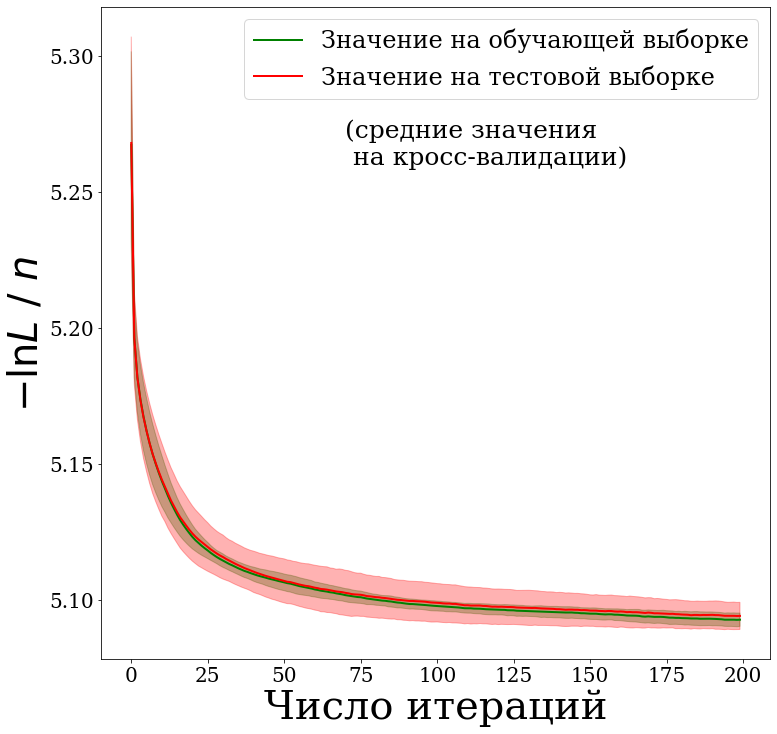

In [44]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40


iter_start = 0


x = np.arange(iter_start, 200)


n = len(xs)
k = n // 5

ln_L_tr_array = np.array([cv_res[i][3] for i in range(5)])

ln_L_tr_mean = np.mean(ln_L_tr_array, axis = 0)[iter_start:]

ln_L_tr_std = np.std(ln_L_tr_array, axis = 0)[iter_start:]

lim_1_tr = -(ln_L_tr_mean - ln_L_tr_std)/(n-k)
lim_2_tr = -(ln_L_tr_mean + ln_L_tr_std)/(n-k)


ln_L_test_array = np.array([cv_res[i][4] for i in range(5)])

ln_L_test_mean = np.mean(ln_L_test_array, axis = 0)[iter_start:]

ln_L_test_std = np.std(ln_L_test_array, axis = 0)[iter_start:]


lim_1_test = -(ln_L_test_mean - ln_L_test_std)/k
lim_2_test = -(ln_L_test_mean + ln_L_test_std)/k


plt.figure(figsize = (12,12))

plt.plot(x, -ln_L_tr_mean/(n-k), c = 'green', label = 'Значение на обучающей выборке')
plt.fill(np.concatenate((x, x[::-1])), np.concatenate((lim_1_tr, lim_2_tr[::-1])), color = 'green', alpha = 0.3)
plt.plot(x, -ln_L_test_mean/k, c = 'red', label = 'Значение на тестовой выборке')
plt.fill(np.concatenate((x, x[::-1])), np.concatenate((lim_1_test, lim_2_test[::-1])), color = 'red', alpha = 0.3)
plt.text(70, 5.26, '(средние значения \n на кросс-валидации)', fontsize = 25)
plt.legend(loc = 'best')
plt.xlabel("Число итераций")
plt.ylabel("$ - \ln L \ / \ n  $")
plt.show()

In [29]:
(ln_L_tr_mean - ln_L_tr_std)/(n-k)

array([-5.30180793, -5.21098467, -5.19507321, -5.18650723, -5.17991269,
       -5.17431055, -5.16926479, -5.16476064, -5.16065798, -5.15675744,
       -5.15317423, -5.14964278, -5.14633033, -5.1430808 , -5.14031714,
       -5.13761969, -5.1352707 , -5.13321272, -5.13121614, -5.12936719,
       -5.12759988, -5.12599076, -5.12471846, -5.12345049, -5.12225557,
       -5.12119081, -5.12004673, -5.11906312, -5.11820515, -5.117578  ,
       -5.11694636, -5.11620103, -5.11561461, -5.11510515, -5.11453395,
       -5.11398087, -5.11356944, -5.1130989 , -5.11273126, -5.11234009,
       -5.1120851 , -5.11177234, -5.11143665, -5.11121752, -5.11104543,
       -5.11074325, -5.11056886, -5.11035919, -5.11008957, -5.10985813,
       -5.10954311, -5.10928503, -5.10911909, -5.10883514, -5.10855176,
       -5.10818444, -5.10791065, -5.10763955, -5.10738624, -5.1071142 ,
       -5.10664025, -5.10646205, -5.1061821 , -5.10594093, -5.10571044,
       -5.10540863, -5.1052358 , -5.10494749, -5.10474093, -5.10

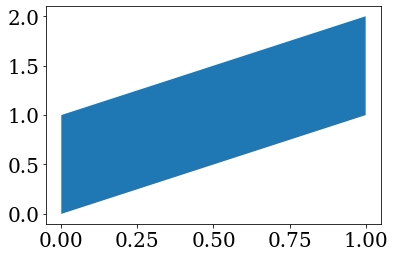

In [22]:
x = np.linspace(0,1)
y = x
y1 = x + 1
plt.fill(np.concatenate((x, x[::-1])), np.concatenate((y, y1[::-1])))

In [113]:
g_opt_AIC, distributions_opt_AIC, probs_opt_AIC, fit_res_AIC = choose_best_AIC(xs, 2, 7)

Processing g = 2...
Processing g = 3...
Processing g = 4...
Processing g = 5...
Processing g = 6...
Processing g = 7...


In [13]:
g_opt_AIC, distributions_opt_AIC, probs_opt_AIC, fit_res_AIC = choose_best_AIC(xs, 8, 8)

Processing g = 8...


In [114]:
g_opt

2

In [14]:
fit_res_AIC[-1][0]

[kent(2.675309019467184, -0.5340725968874167, -0.8007947035136526, 13.399978511981821, 1.9244870385788353),
 kent(1.110574746923836, 1.5425555737251726, -1.9838549979077311, 5.585790117971687, 0.2558040850121659),
 kent(2.295929805355462, -2.0367011492658915, 0.494638170359299, 9.863389457695316, 0.6157672943814316),
 kent(1.9369679845731615, 2.9114083620947966, -1.6275076281265413, 13.680761899058753, 2.8471381908724203),
 kent(2.1840445708152267, 0.8930447622795213, -0.5520546228196986, 4.8351155304170135, 0.010679532652207557),
 kent(1.7806189807021695, -0.9955656585018388, -2.16994978371866, 5.476949951025729, 0.3363506199477402),
 kent(0.9203919251043542, -1.96837739727397, -0.3397218713754564, 3.1809003160108187, 0.09053971377817405),
 kent(1.1345430254095759, 0.21357008105343403, 0.6292019124371104, 12.617275128850697, 2.1172027696343174)]

In [168]:
def normalize(l):
    while l >= 2*pi:
        l -= 2*pi
    while l < 0:
        l += 2*pi
    return l

In [190]:
theta_extr = np.array([normalize(k.theta) for k in fit_res_AIC_r[0][1]])
phi_extr = np.array([normalize(k.phi) for k in fit_res_AIC_r[0][1]])
r_extr = np.array([nd.mu for nd in fit_res_AIC_r[0][0]])

In [172]:
def final_pdf_r(r, Theta, Phi, normal_distributions, distributions, probs):
    Z = np.zeros(Theta.shape)
    for i in range(Theta.shape[0]):
        for j in range(Theta.shape[1]):
            theta = Theta[i,j]*pi/180
            phi = Phi[i,j]*pi/180
            x1 = np.cos(theta)
            x2 = np.sin(theta)*np.cos(phi)
            x3 = np.sin(theta)*np.sin(phi)
            x = np.array([[x1, x2, x3]])
            Z[i,j] = np.sum([normal_distribution.pdf(r)*distribution.pdf(x)*prob \
                                     for normal_distribution, distribution, prob \
                                     in zip(normal_distributions, distributions, probs)])
    return Z

In [257]:
r = 15

theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 361)

Theta, Phi = np.meshgrid(theta, phi)
Pdf = final_pdf_r(r, Theta, Phi, normal_distributions_opt_AIC_r, distributions_opt_AIC_r, probs_opt_AIC_r)

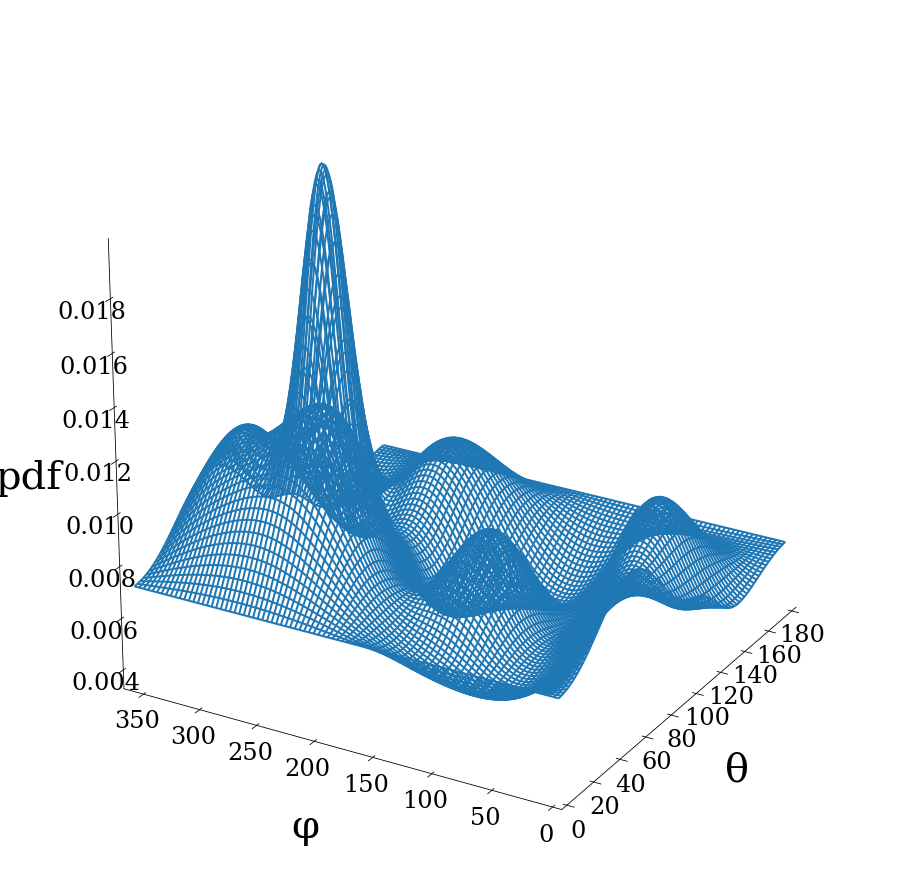

In [274]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40


fig = plt.figure(figsize =(16,16))
ax = fig.add_subplot(111, projection='3d')


ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.plot_wireframe(Theta, Phi, Pdf, rcount = 100, ccount = 100)
ax.view_init(25, 210)
ax.set_xlabel('\u03B8', labelpad=35)
ax.set_ylabel('\u03C6', labelpad=35)
ax.set_zlabel('pdf', labelpad=35)
ax.set_xlim(0, 180)
ax.set_ylim(0, 360)

plt.show()

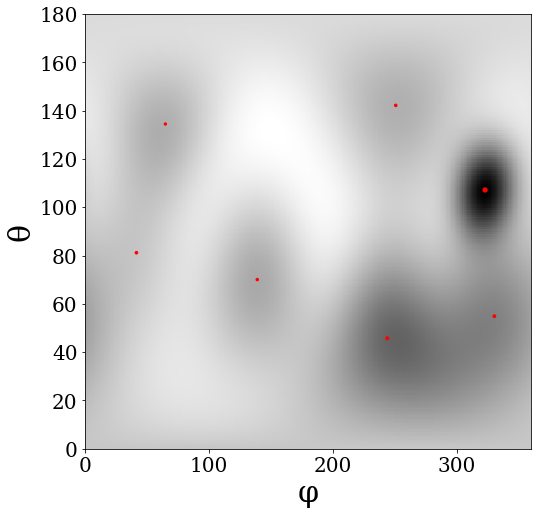

In [259]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40

theta, phi = discretisation_bins[r].T
plt.figure(figsize = (8,8))
s = 2000/len(theta)

#plt.title('$r = '+str(r)+' \pm 0.5$')

plt.xlim(0, 360)
plt.ylim(0, 180)
plt.xlabel('\u03C6', fontsize = 30)
plt.ylabel('\u03B8', fontsize = 30)
plt.pcolormesh(Pdf.T, cmap = 'gray_r')

relevance_mask = (r_extr >= r - 2) * (r_extr < r + 2)

size = np.array([k.kappa for k in fit_res_AIC_r[0][1]])*np.array(probs_opt_AIC_r)/ \
        np.array([nd.sigma_sq for nd in fit_res_AIC_r[0][0]])

plt.scatter(phi_extr[relevance_mask]*180/pi, theta_extr[relevance_mask]*180/pi, s = 100*size[relevance_mask], color = 'red')
plt.show()

In [236]:
def final_pdf_eucl_r(r, Theta, Phi, normal_distributions, distributions, probs, alpha = 1):
    X = np.zeros(Theta.shape)
    Y = np.zeros(Theta.shape)
    Z = np.zeros(Theta.shape)
    for i in range(Theta.shape[0]):
        for j in range(Theta.shape[1]):
            theta = Theta[i,j]*pi/180
            phi = Phi[i,j]*pi/180
            x1 = np.cos(theta)
            x2 = np.sin(theta)*np.cos(phi)
            x3 = np.sin(theta)*np.sin(phi)
            x = np.array([[x1, x2, x3]])
            R = alpha*np.sum([normal_distribution.pdf(r)*distribution.pdf(x)*prob \
                                     for normal_distribution, distribution, prob \
                                     in zip(normal_distributions, distributions, probs)]) + 1
            X[i,j] = R*np.cos(theta)
            Y[i,j] = R*np.sin(theta)*np.cos(phi)
            Z[i,j] = R*np.sin(theta)*np.sin(phi)
    return X, Y, Z

In [277]:
r = 15

theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 361)

Theta, Phi = np.meshgrid(theta, phi)

X, Y, Z = final_pdf_eucl_r(r, Theta, Phi, normal_distributions_opt_AIC_r, distributions_opt_AIC_r, probs_opt_AIC_r, alpha = 50)

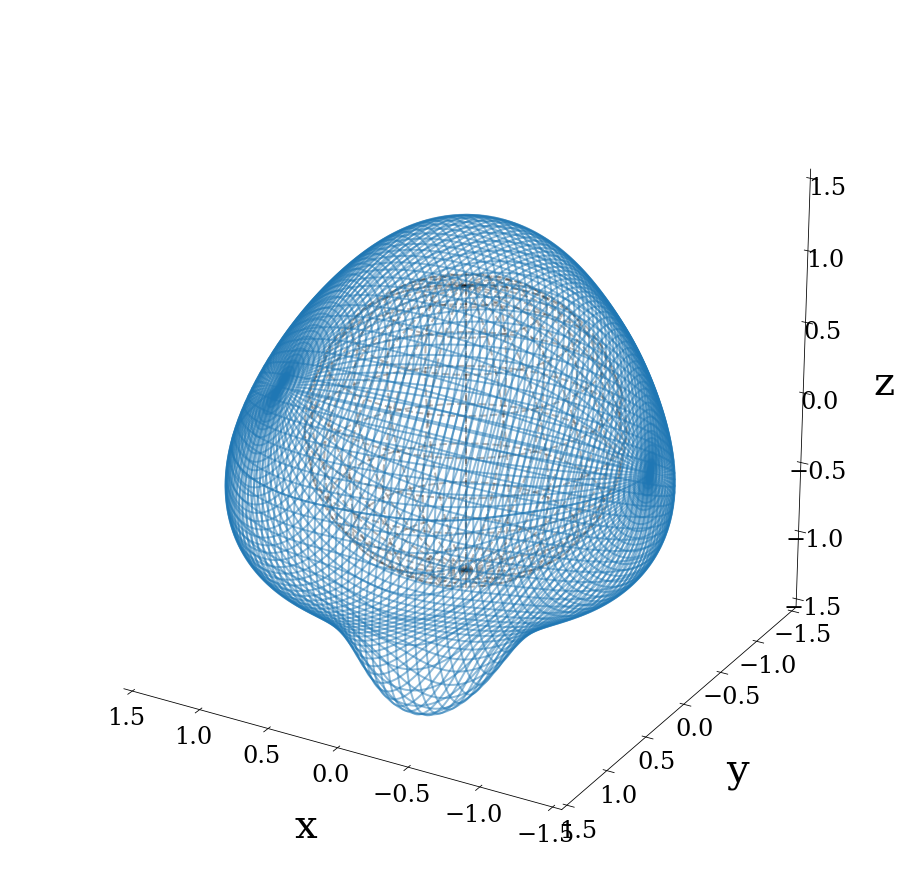

In [280]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40


fig = plt.figure(figsize =(16,16))
ax = fig.add_subplot(111, projection='3d')


ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

draw_sphere(ax, alpha = 0.3)
ax.plot_wireframe(X, Y, Z, alpha = 0.5, rcount = 100, ccount = 100)
ax.view_init(25, 120)
ax.set_xlabel('x', labelpad=35)
ax.set_ylabel('y', labelpad=35)
ax.set_zlabel('z', labelpad=35)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

plt.show()

In [198]:
r_extr[(r_extr >= r - 0.5) * (r_extr < r + 0.5)]

array([10.89334882, 10.9176232 , 10.97836677])

In [ ]:
phi_extr

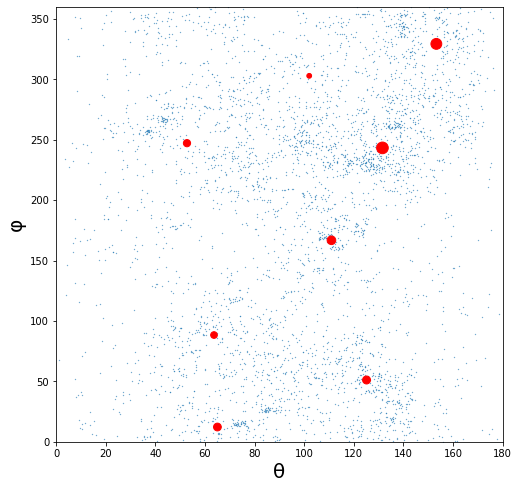

In [17]:
theta, phi = discretisation_bins['8-9'].T
plt.figure(figsize = (8,8))
s = 300/len(theta)
plt.scatter(np.array(theta)*180/pi, np.array(phi)*180/pi, s = s)
plt.scatter(np.array(theta_extr)*180/pi, np.array(phi_extr)*180/pi, s = 1000*s*np.array([k.kappa for k in fit_res_AIC[0][0]])*np.array(probs_opt_AIC), c = 'r')
plt.xlabel('\u03B8', fontsize = 20)
plt.ylabel('\u03C6', fontsize = 20)
plt.xlim(0, 180)
plt.ylim(0, 360)
plt.show()

In [68]:
(5.5*pi % 2*pi)*180/pi

230.17672705389487

In [72]:
normalize(5.5*pi)

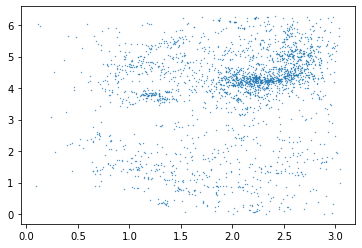

In [101]:
theta, phi = discretisation_bins['6-7'].T
s = 300/len(theta)
plt.scatter(theta, phi, s = s)
#plt.scatter(theta_extr, phi_extr, s = 100*s, c = 'r')
plt.show()

In [18]:
def final_pdf(Theta, Phi, distributions, probs):
    Z = np.zeros(Theta.shape)
    for i in range(Theta.shape[0]):
        for j in range(Theta.shape[1]):
            theta = Theta[i,j]*pi/180
            phi = Phi[i,j]*pi/180
            x1 = np.cos(theta)
            x2 = np.sin(theta)*np.cos(phi)
            x3 = np.sin(theta)*np.sin(phi)
            x = np.array([[x1, x2, x3]])
            Z[i,j] = np.sum([distribution.pdf(x)*prob for distribution, prob in zip(distributions, probs)])
    return Z

def Angular_Grid_to_Cartesian_Grid(Theta, Phi):
    a,b = Theta.shape
    
    X = np.zeros((a,b,3))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            theta = Theta[i,j]
            phi = Phi[i,j]
            X[i,j, 0] = np.cos(theta)
            X[i,j, 1] = np.sin(theta)*np.cos(phi)
            X[i,j, 2] = np.sin(theta)*np.sin(phi)

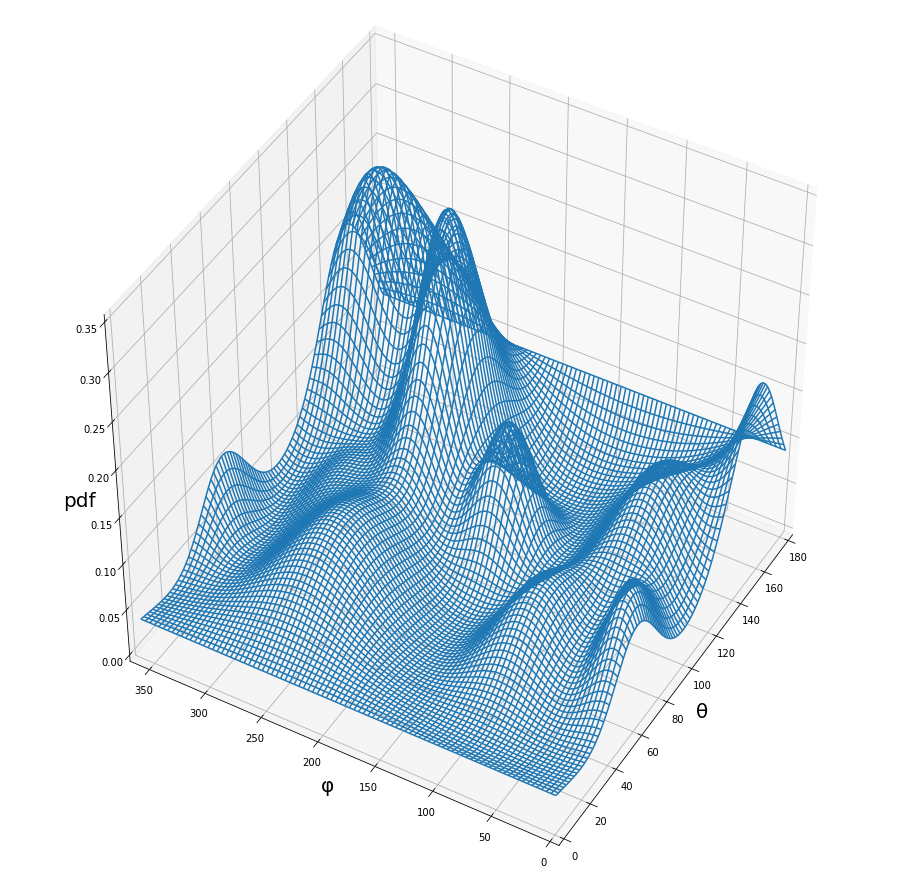

In [20]:

theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 361)

Theta, Phi = np.meshgrid(theta, phi)





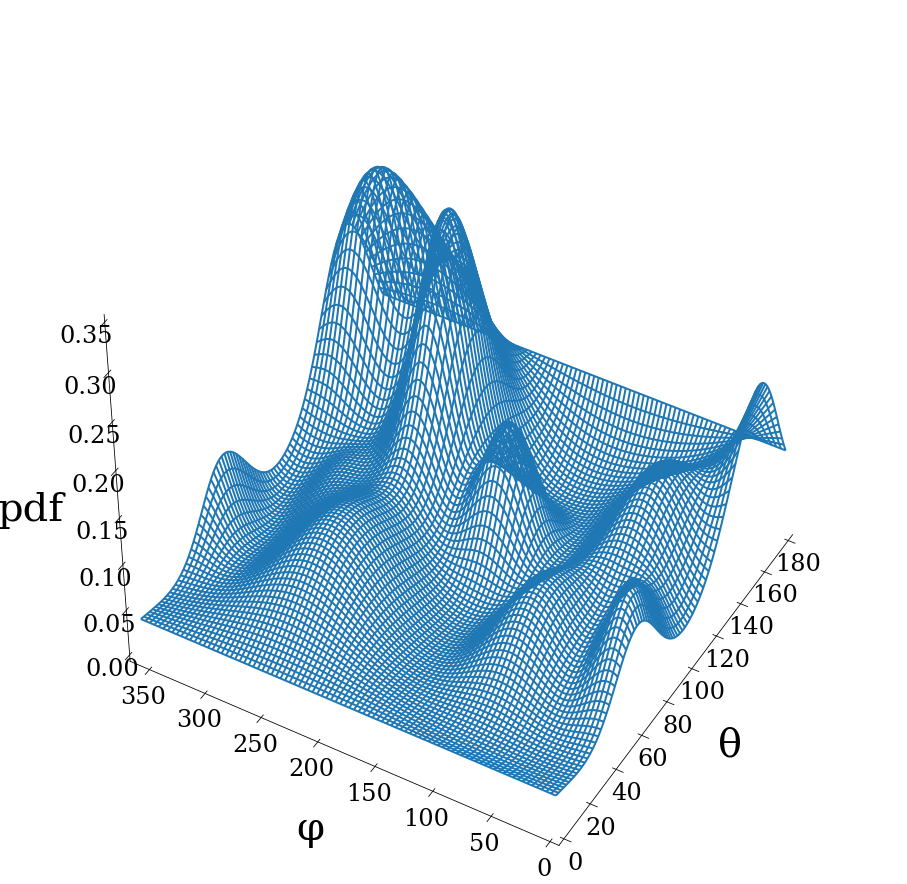

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40


fig = plt.figure(figsize =(16,16))
ax = fig.add_subplot(111, projection='3d')


ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.plot_wireframe(Theta, Phi, final_pdf(Theta, Phi, distributions_opt_AIC, probs_opt_AIC), rcount = 100, ccount = 100)
ax.view_init(45, 210)
ax.set_xlabel('\u03B8', labelpad=35)
ax.set_ylabel('\u03C6', labelpad=35)
ax.set_zlabel('pdf', labelpad=35)
ax.set_xlim(0, 180)
ax.set_ylim(0, 360)
ax.set_zlim(0, 0.35)

plt.show()

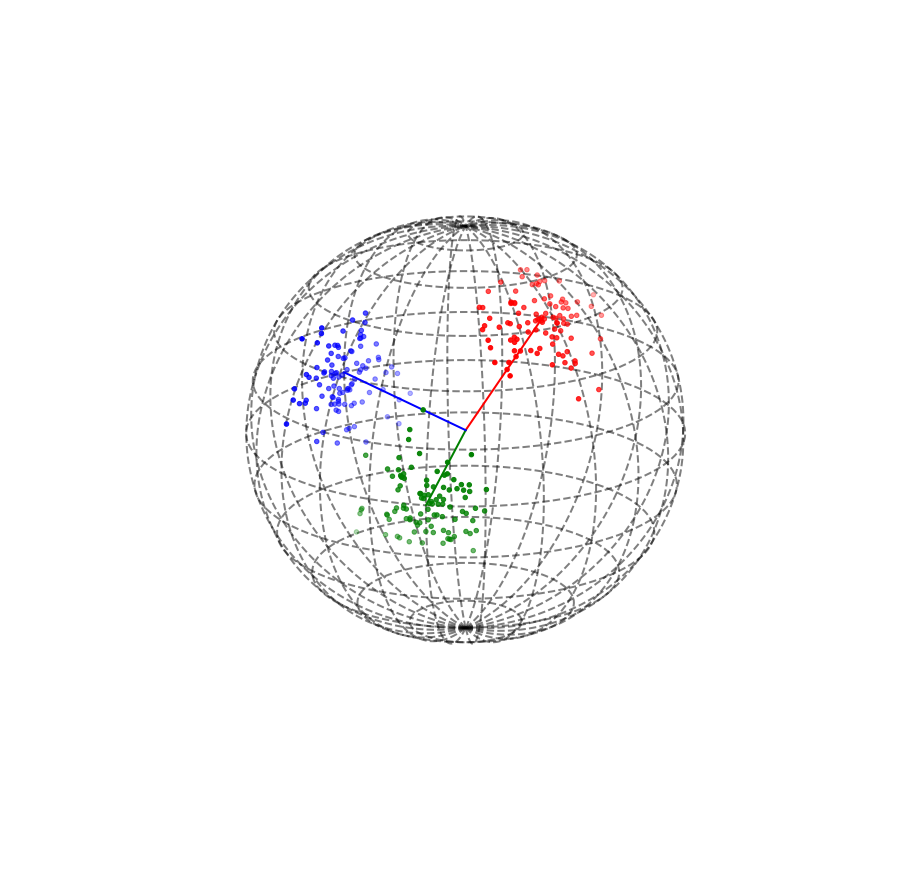

In [111]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(20, 10)
ax.set_axis_off()


draw_sphere(ax)

k = kent(pi/3, pi/3, 0, 50, 2)
xs = k.rvs(n_samples = 100)
ax.scatter(xs[:,0], xs[:, 1], xs[:, 2], color = 'red')
g = k.gamma1
ax.plot([0,g[0]],[0, g[1]], [0,g[2]], color = 'red')

k = kent(0, 3*pi/2, 0, 50, 2)
xs = k.rvs(n_samples = 100)
ax.scatter(xs[:,0], xs[:, 1], xs[:, 2], color = 'green')
g = k.gamma1
ax.plot([0,g[0]],[0, g[1]], [0,g[2]], color = 'green')

k = kent(3*pi/4, pi, 0, 50, 2)
xs = k.rvs(n_samples = 100)
ax.scatter(xs[:,0], xs[:, 1], xs[:, 2], color = 'blue')
g = k.gamma1
ax.plot([0,g[0]],[0, g[1]], [0,g[2]], color = 'blue')

plt.show()

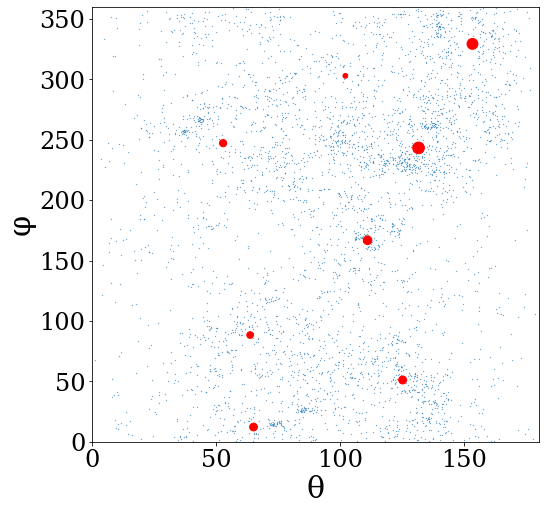

In [79]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40



theta, phi = discretisation_bins['8-9'].T
plt.figure(figsize = (8,8))
s = 300/len(theta)
plt.scatter(np.array(theta)*180/pi, np.array(phi)*180/pi, s = s)
plt.scatter(np.array(theta_extr)*180/pi, np.array(phi_extr)*180/pi, s = 1000*s*np.array([k.kappa for k in fit_res_AIC[0][0]])*np.array(probs_opt_AIC), c = 'r', label = 'максимумы плотности')
plt.xlabel('\u03B8', fontsize = 30)
plt.ylabel('\u03C6', fontsize = 30)

plt.xlim(0, 180)
plt.ylim(0, 360)
plt.show()

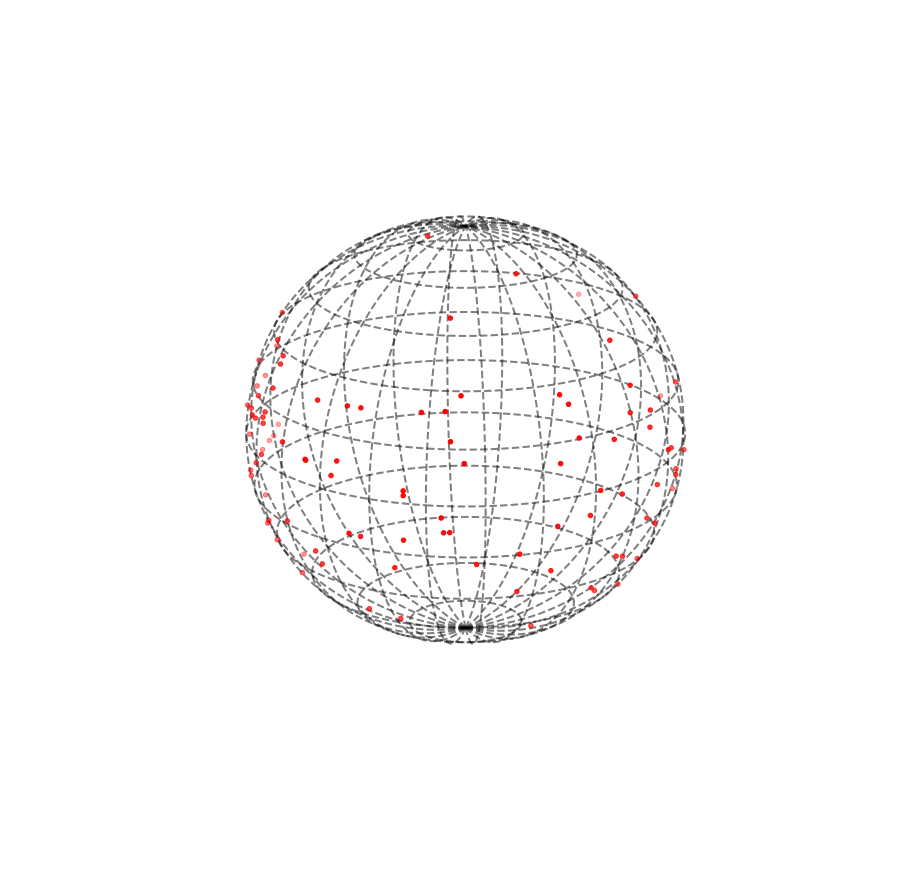

In [84]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(20, 10)

draw_sphere(ax)
ax.set_axis_off()
k = kent(0, 0, 0, 2, 2)
xs = k.rvs(n_samples = 100)
ax.scatter(xs[:,0], xs[:, 1], xs[:, 2], color = 'red')

plt.show()

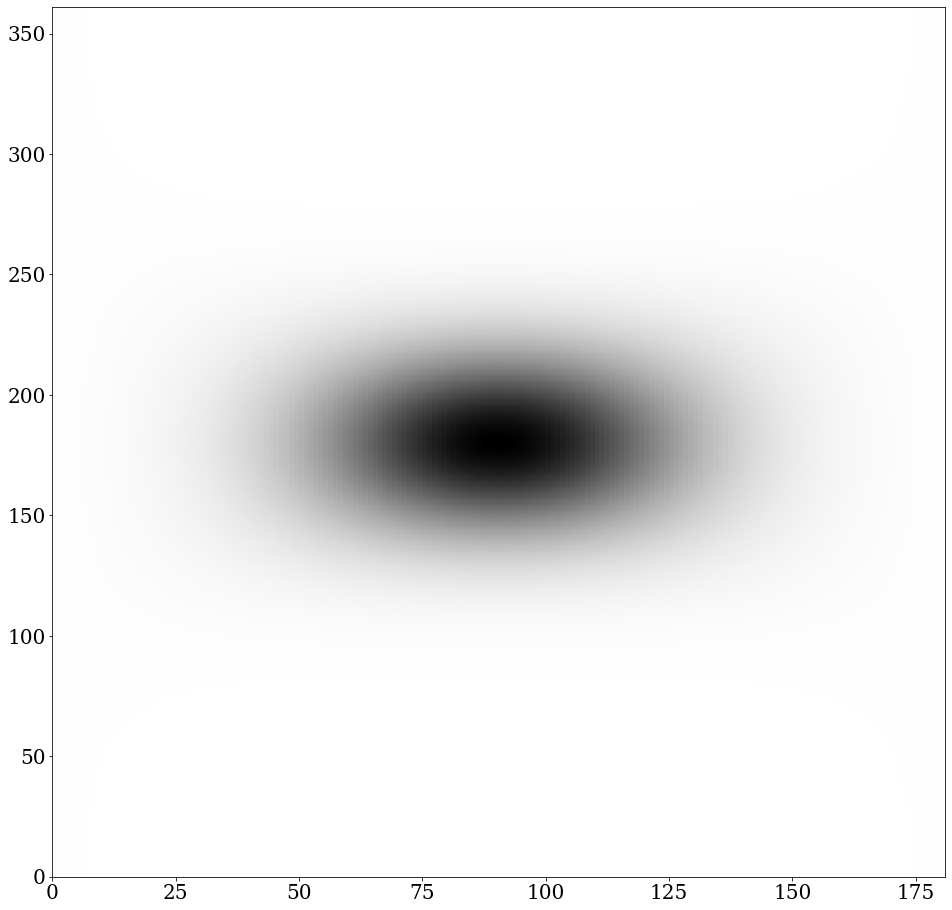

In [157]:
# plt.rcParams['font.family'] = 'DejaVu Serif'
# plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 12
# plt.rcParams['xtick.labelsize'] = 24
# plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['legend.fontsize'] = 24
# plt.rcParams['axes.titlesize'] = 36
# plt.rcParams['axes.labelsize'] = 40

k = kent(pi/2, pi, 0 , 5, 0)
#print(k.gamma1)
#print(k.gamma2)
#print(k.gamma3)
theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 361)

Theta, Phi = np.meshgrid(theta, phi)


def pdf(Theta, Phi, k):
    Z = np.zeros(Theta.shape)
    for i in range(Theta.shape[0]):
        for j in range(Theta.shape[1]):
            theta = Theta[i,j]*pi/180
            phi = Phi[i,j]*pi/180
            x1 = np.cos(theta)
            x2 = np.sin(theta)*np.cos(phi)
            x3 = np.sin(theta)*np.sin(phi)
            x = np.array([[x1, x2, x3]])
            Z[i,j] = k.pdf(x)
    return Z
    

fig = plt.figure(figsize =(16,16))
# ax = fig.add_subplot(111, projection='3d')


# ax.grid(False)
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# ax.plot_wireframe(Theta, Phi, pdf(Theta, Phi, k), rcount = 100, ccount = 100)
# ax.view_init(30, 210)
# ax.set_xlabel('\u03B8', labelpad=35, fontsize = 25)
# ax.set_ylabel('\u03C6', labelpad=35, fontsize = 25)
# ax.set_zlabel('pdf', labelpad=35, fontsize = 25)
# ax.set_xlim(0, 180)
# ax.set_ylim(0, 360)
# ax.set_zlim(0, 1.5)

# plt.show()


plt.pcolormesh(pdf(Theta, Phi, k), cmap = 'gray_r')
plt.show()

In [137]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40


theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 361)




Theta, Phi = np.meshgrid(theta, phi)

X, Y, Z = final_pdf_eucl(Theta, Phi, distributions_opt_AIC, probs_opt_AIC, alpha = 5)

NameError: name 'distributions_opt_AIC' is not defined

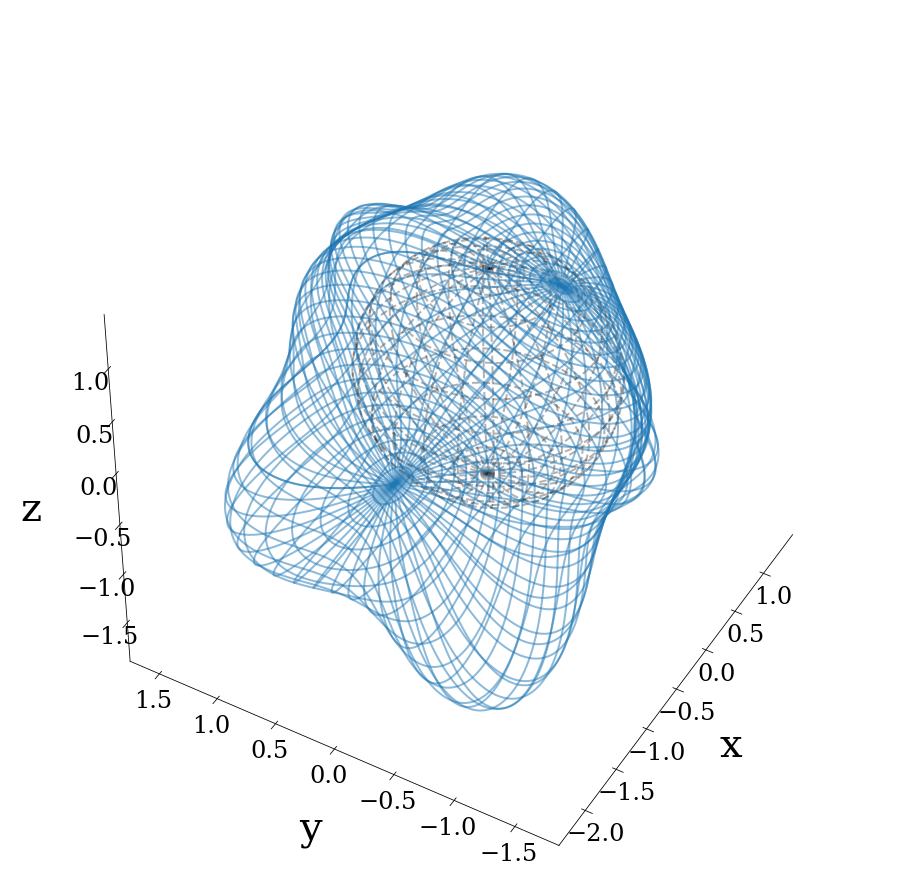

In [118]:
fig = plt.figure(figsize =(16,16))
ax = fig.add_subplot(111, projection='3d')


ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

draw_sphere(ax, alpha = 0.3)
ax.plot_wireframe(X, Y, Z, alpha = 0.5)
ax.view_init(45, 210)
ax.set_xlabel('x', labelpad=35)
ax.set_ylabel('y', labelpad=35)
ax.set_zlabel('z', labelpad=35)

plt.show()

In [140]:
def draw_sphere(ax, alpha = 0.5):

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(-pi/2, pi/2, 100)

    #x = 1 * np.outer(np.cos(u), np.sin(v))
    #y = 1 * np.outer(np.sin(u), np.sin(v))
    #z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
    #for i in range(2):
    #    ax.plot_surface(x+random.randint(-5,5), y+random.randint(-5,5), z+random.randint(-5,5),  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)
    for theta in [-6*pi/12, -5*pi/12, -4*pi/12, -3*pi/12, -2*pi/12, -pi/12, 0, pi/12, 2*pi/12, 3*pi/12, 4*pi/12, 5*pi/12, 6*pi/12]:
#ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)
        ax.plot(np.cos(u)*np.cos(theta),np.sin(u)*np.cos(theta),np.sin(theta), '--', color='k',alpha = alpha)
#ax.plot([0]*100,np.sin(v),np.cos(u),color='k')
    for phi in [-6*pi/12, -5*pi/12, -4*pi/12, -3*pi/12, -2*pi/12, -pi/12, 0, pi/12, 2*pi/12, 3*pi/12, 4*pi/12, 5*pi/12, 6*pi/12, \
           7*pi/12, 8*pi/12, 9*pi/12, 10*pi/12, 11*pi/12, 12*pi/12, 13*pi/12, 14*pi/12, 15*pi/12, 16*pi/12, 17*pi/12]:
        ax.plot(np.sin(phi)*np.cos(v),np.cos(phi)*np.cos(v),np.sin(v), '--', color='k', alpha = alpha)


def final_pdf_eucl(Theta, Phi, distributions, probs, alpha = 1):
    X = np.zeros(Theta.shape)
    Y = np.zeros(Theta.shape)
    Z = np.zeros(Theta.shape)
    for i in range(Theta.shape[0]):
        for j in range(Theta.shape[1]):
            theta = Theta[i,j]*pi/180
            phi = Phi[i,j]*pi/180
            x1 = np.cos(theta)
            x2 = np.sin(theta)*np.cos(phi)
            x3 = np.sin(theta)*np.sin(phi)
            x = np.array([[x1, x2, x3]])
            R = alpha*np.sum([distribution.pdf(x)*prob for distribution, prob in zip(distributions, probs)]) + 1
            X[i,j] = R*np.cos(theta)
            Y[i,j] = R*np.sin(theta)*np.cos(phi)
            Z[i,j] = R*np.sin(theta)*np.sin(phi)
    return X, Y, Z

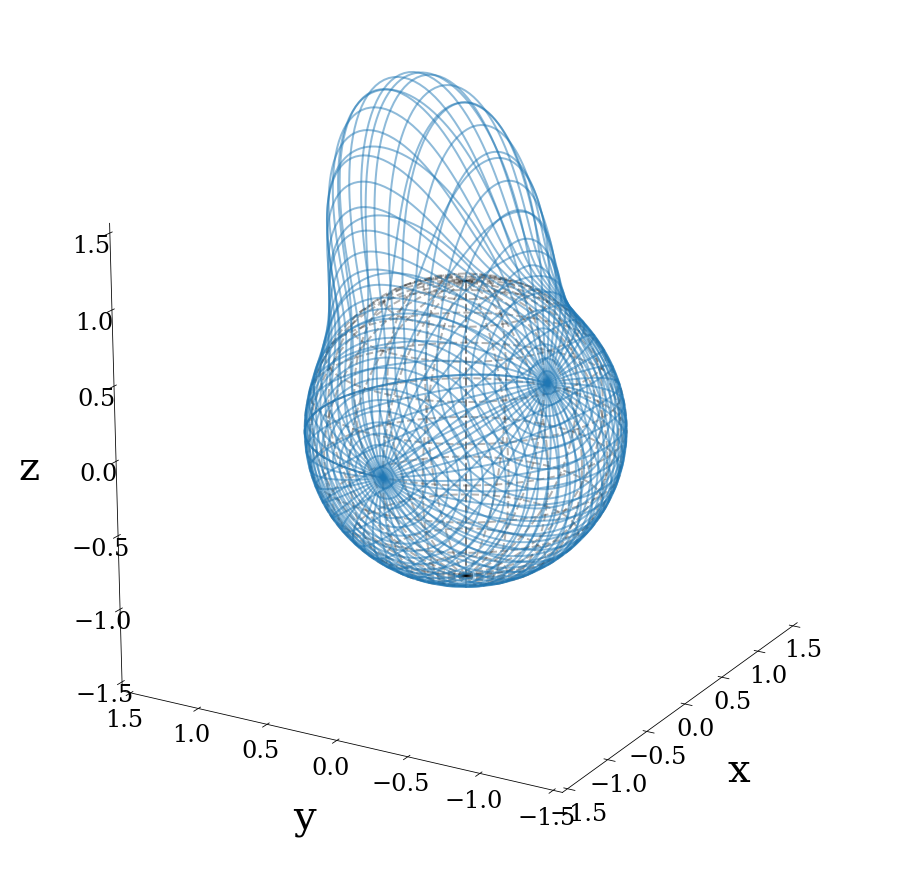

In [142]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 40


k = kent(pi/3, pi/3, 0, 10, 2)

X, Y, Z = final_pdf_eucl(Theta, Phi, np.array([k]), np.array([1]), alpha = 1)

fig = plt.figure(figsize =(16,16))
ax = fig.add_subplot(111, projection='3d')


ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

draw_sphere(ax, alpha = 0.3)
ax.plot_wireframe(X, Y, Z, alpha = 0.5)
ax.view_init(20, 210)
ax.set_xlabel('x', labelpad=35)
ax.set_ylabel('y', labelpad=35)
ax.set_zlabel('z', labelpad=35)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

plt.show()